# MobileBERT for Question Answering on the SQuAD dataset

### 2. Fine-tuning the model

In these notebooks we are going to use [MobileBERT implemented by HuggingFace](https://huggingface.co/docs/transformers/model_doc/mobilebert) on the question answering task by text-extraction on the [The Stanford Question Answering Dataset (SQuAD)](https://rajpurkar.github.io/SQuAD-explorer/). The data is composed of a set of questions and paragraphs that contain the answers. The model will be trained to locate the answer in the context by giving the positions where the answer starts and ends.

In this notebook we are going to Fine-tune the model.

More info from HuggingFace docs:
- [Question Answering](https://huggingface.co/tasks/question-answering)
- [Glossary](https://huggingface.co/transformers/glossary.html#model-inputs)
- [Question Answering chapter of NLP course](https://huggingface.co/learn/nlp-course/chapter7/7?fw=pt)

In [1]:
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, MobileBertForQuestionAnswering
from datasets import load_dataset
from torch.utils.data import DataLoader

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets.utils import disable_progress_bar
from datasets import disable_caching


disable_progress_bar()
disable_caching()

In [3]:
# Extract the tokenizer that was used for pretraining that model
# We want to use https://huggingface.co/google/mobilebert-uncased
hf_model_checkpoint = "google/mobilebert-uncased"
tokenizer = AutoTokenizer.from_pretrained(hf_model_checkpoint)


In [4]:
# instantiate the model
# We will use the model MobileBertForQuestionAnswering that we imported on the first cell
# Use this as reference
# https://huggingface.co/docs/transformers/model_doc/mobilebert#transformers.MobileBertForPreTraining.forward.example
model = MobileBertForQuestionAnswering.from_pretrained(hf_model_checkpoint)

Some weights of MobileBertForQuestionAnswering were not initialized from the model checkpoint at google/mobilebert-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Question

When instantiating model, there's a red message coming up. What does it mean?

In [5]:
# load the dataset
hf_dataset = load_dataset('squad')

In [6]:
# Preprocessing data
# Include here all the preprocessing that was done on the notebook about exploring the dataset
# and apply it via the dataset filter and the map 
MAX_SEQ_LEN = 300

def tokenize_dataset(squad_example, tokenizer=tokenizer):
    """Tokenize the text in the dataset and convert
    the start and ending positions of the answers
    from text to tokens"""
    max_len = MAX_SEQ_LEN
    context = squad_example['context']
    answer_start = squad_example['answers']['answer_start'][0]
    answer = squad_example['answers']['text'][0]
    squad_example_tokenized = tokenizer(
        context, squad_example['question'],
        padding='max_length',
        max_length=max_len,
        truncation='only_first',
    )
    token_start = len(tokenizer.tokenize(context[:answer_start + 1]))
    token_end = len(tokenizer.tokenize(answer)) + token_start

    squad_example_tokenized['start_token_idx'] = token_start
    squad_example_tokenized['end_token_idx'] = token_end

    return squad_example_tokenized

def filter_samples_by_max_seq_len(squad_example):
    """Fliter out the samples where the answers are
    not within the first `MAX_SEQ_LEN` tokens"""
    max_len = MAX_SEQ_LEN
    answer_start = squad_example['answers']['answer_start'][0]
    answer = squad_example['answers']['text'][0]
    token_start = len(tokenizer.tokenize(squad_example['context'][:answer_start]))
    token_end = len(tokenizer.tokenize(answer)) + token_start
    return token_end < max_len

dataset_filtered = hf_dataset.filter(
    filter_samples_by_max_seq_len,
    num_proc=24,
)

dataset_tok = dataset_filtered.map(
    tokenize_dataset,
    remove_columns=hf_dataset['train'].column_names,
    num_proc=24,
)
dataset_tok.set_format('pt')
dataset_tok

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_token_idx', 'end_token_idx'],
        num_rows: 87289
    })
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'start_token_idx', 'end_token_idx'],
        num_rows: 10511
    })
})

In [7]:
# Define a PyTorch Dataloader for the train set
# Use batch size 256 for a fast training
batch_size = 256

# Define a PyTorch Dataloader for the train set
train_dataloader = DataLoader(
    dataset_tok['train'],
    shuffle=False,
    batch_size=batch_size,
)

In [8]:
# Move the model to the GPU 0
device = 0
model.to(device)
model.train()

MobileBertForQuestionAnswering(
  (mobilebert): MobileBertModel(
    (embeddings): MobileBertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (embedding_transformation): Linear(in_features=384, out_features=512, bias=True)
      (LayerNorm): NoNorm()
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): MobileBertEncoder(
      (layer): ModuleList(
        (0-23): 24 x MobileBertLayer(
          (attention): MobileBertAttention(
            (self): MobileBertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=512, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): MobileBertSelfOutput(
              (dense): Linear(in_feature

## Training

We are going to train for two epocs. We will use a different learning rate values in each epoch:
 - epoch 1: `lr = 2e-4` (to move fast on the loss function over the parameter space)
 - epoch 2: `lr = 2e-5` (to avoid jumping around and start converging towards a minimum)

We will do this manually:
 - Run epoch one
 - Redifine the optimizer with the new learning rate and run again the training

We should aim to loss values around 0.6, which will ensure "decent" predictions

In [14]:
# Define optimizer using "AdamW" (Adam with decoupled weight decay)
params = model.parameters()
my_optimizer = torch.optim.AdamW(params, lr=2e-5)

In [10]:
def log(loss):
    """Utility function for plotting"""

    return loss.cpu().detach().numpy()

In [15]:
history = []

for epoch in range(1):
    for i, batch in enumerate(train_dataloader):
        my_optimizer.zero_grad()  # reset automatic differentiation record
        # evaluate the model and pass the output references (start_token_idx and end_token_idx)
        outputs = model(input_ids=batch['input_ids'].to(device),
                        token_type_ids=batch['token_type_ids'].to(device),
                        attention_mask=batch['attention_mask'].to(device),
                        start_positions=batch['start_token_idx'].to(device),
                        end_positions=batch['end_token_idx'].to(device))        
        loss = outputs[0]          # obtain the loss from the model output (specific of HugginFace's API)
        history.append(log(loss))  # [not part of the traing] keep values for plotting later
        loss.backward()    # Add the back propagation from the loss
        my_optimizer.step()    # update weights with the gradients

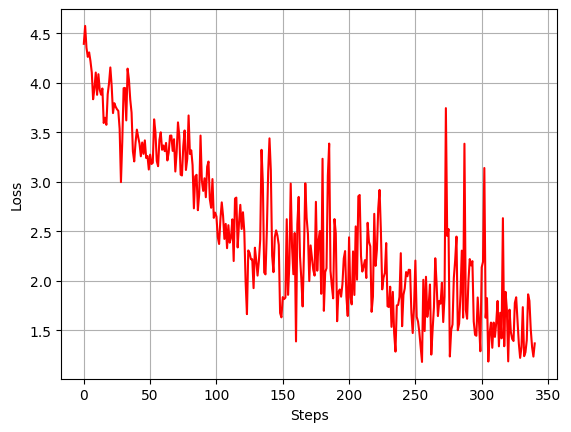

In [16]:
plt.plot(history, 'r-')
plt.ylabel('Loss')
plt.xlabel('Steps')
plt.grid()
plt.show()

In [17]:
# Save the mode to disk
torch.save(model.state_dict(), 'mobilebertqa_ft_final')

## Evaluating the model

When your model is trained, run the notebook `3_mobilebert-squad-testing.ipynb` to test it on the validation set.